# Introduction

The purpose of this small project is to compare the performance of dense layer neural networks methods to predict the quality of wine from the [wine quality dataset](https://archive.ics.uci.edu/ml/datasets/wine+quality).

Wine's quality can take decimal values (i.e. 7.25), regardless of the fact that only integers are found in the training dataset. Therefore, this is a `regression` task.

For the comparison, an evaluation of a base model, a lasso-regularized model, a drop-out regularization and regularized models with early stopping will be compared to see which one provides the best results.

### Regularization Techniques in Deep Learning

Regularization is a technique used to prevent overfitting in a model. Overfitting occurs when the model performs well on the training data but poorly on the unseen data (like validation or test data). Regularization adds a penalty on the different parameters of the model to reduce the freedom of the model and in other words to avoid overfitting.

### L1 and L2 Regularization

L1 and L2 are the most common types of regularization. These update the general cost function by adding another term known as the regularization term. For this evaluation, we will focus on L1 Lasso regularization

- L1 Regularization (Lasso Regression)
In L1, we shrink the parameters to zero, thus removing some features and making the model simpler and interpretable.

Here's the formula for L1 Regularization:

$$
L1 = \lambda \sum_{i=1}^{n} |w_{i}|
$$

### Dropout
Dropout is a technique where randomly selected neurons are ignored during training, meaning that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass. It has the effect of reducing overfitting and improving model performance.

### Early Stopping
Early stopping is a form of regularization used to avoid overfitting when training a learner with an iterative method, such as gradient descent. These methods update the learner so as to make it better fit the training data with each iteration. Up to a point, this improves the learner's performance on data outside of the training set. Past that point, however, improving the learner's fit to the training data comes at the expense of increased generalization error AKA overfitting.

# 0. Import of packages

#### Import of necessary packages

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
tf.random.set_seed(0)

#### Definition of useful functions

In [ ]:
def show_loss_accuracy_evolution(history, model_name):

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, (ax1) = plt.subplots(1, figsize=(16, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE')
    ax1.set_title(f'Train-val epoch evolution of {model_name}')
    ax1.plot(hist['epoch'], hist['loss'], label='Train Error')
    ax1.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    ax1.grid()
    ax1.legend()

    plt.show()


def show_samples(x_test, y_test, model):
    predictions = model.predict(x_test)
    predicted_classes = np.argmax(predictions, -1)

    L = 5
    W = 5
    fig, axes = plt.subplots(L, W, figsize=(14, 14))
    axes = axes.ravel()

    for i in np.arange(0, L * W):
        ind = np.random.randint(len(y_test))
        axes[i].imshow(x_test[ind].reshape(28, 28))
        prob_pred = np.max(predictions[ind, :])
        class_pred = int(predicted_classes[ind])
        original_class = int(y_test[ind])
        if class_pred == original_class:
            color = 'green'
        else:
            color = 'red'
        title = "Pred: {0} \n Target: {1} \n Prob: {2:.3f}".format(
        class_pred, original_class, prob_pred)
        axes[i].set_title(title, color=color)
        axes[i].axis('off')

    plt.subplots_adjust(wspace=0.5)

# 1. Data import and preparation for modelling

Given that the purpose of this notebook is merely the comparison of dense-layered neural networks training, the chosen dataset is one that is available in a completely cleaned form.

Additionally, although EDA and Feature Engineering are a desirable, or even a must, for data understanding and preparation for modelling, no effort will be dedicated to those tasks with the intention of centering the attention on the topic of interest.

In [ ]:
df_red = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv',
    sep=';'
)
df_white = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
    sep=';'
)
df = pd.concat([df_red, df_white])

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Feature selection

In [ ]:
feature_names = [
    'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
    'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'
]

y = df.pop('quality').values
X = df.copy().values

### Train-test split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print('x_train, y_train shapes:', x_train.shape, y_train.shape)
print('x_test, y_test shapes:', x_test.shape, y_test.shape)

x_train, y_train shapes: (4872, 11) (4872,)
x_test, y_test shapes: (1625, 11) (1625,)


### Feature normalization

In [ ]:
norm = tf.keras.layers.Normalization(axis=-1)
norm.adapt(x_train)
norm.adapt(x_test)

x_train_norm = norm(x_train).numpy()
x_test_norm = norm(x_test).numpy()

# 2. Modelling
### 2.1 Definition of functions to build the models


In [ ]:
def build_base(n_layers=4, neurons=64, opt ='adam', metrics=['mae']):
  model = keras.Sequential()

  for _ in range(n_layers):
    model.add(layers.Dense(neurons, input_shape=(11,), activation='relu'))

  model.add(layers.Dense(1, activation='linear'))

  model.summary()

  model.compile(
    optimizer= opt,
    loss=tf.keras.losses.MSE,
    metrics= metrics
  )

  return model

def build_dropout(n_layers=4, neurons=64, opt ='adam', metrics=['mae'], drop_pct = 0.4):
  model = keras.Sequential()

  for _ in range(n_layers):
    model.add(layers.Dense(neurons, input_shape=(11,), activation='relu'))
    model.add(layers.Dropout(drop_pct))

  model.add(layers.Dense(1, activation='linear'))

  model.summary()

  model.compile(
    optimizer= opt,
    loss=tf.keras.losses.MSE,
    metrics= metrics
  )

  return model

def build_lasso(n_layers=4, neurons=64, opt ='adam', metrics=['mae'], reg=5e-4):
  kernel_regularizer_lasso = regularizers.l2(reg)
  model = keras.Sequential()

  for _ in range(n_layers):
    model.add(layers.Dense(neurons, input_shape=(11,),kernel_regularizer=kernel_regularizer_lasso, activation='relu'))

  model.add(layers.Dense(1, activation='linear'))

  model.summary()

  model.compile(
    optimizer= opt,
    loss=tf.keras.losses.MSE,
    metrics= metrics
  )

  return model

### 2.2 Model build and fitting

As said earlier, 3 types of overfitting prevention strategies will be evaluated:
- Dropout
- Lasso regularization
- Early stoppage

Early stopagge is compatible with the previous 2 methods of regularization. Thus, 6 models will be evaluated:
1. Baseline model
2. Model with dropout
3. Model with lasso
4. Baseline with early stopping callback
5. Dropout model with early stopping callback
6. Lasso model with early stopping callback

To evaluate them in equal conditions, the models will be built upon the same number of hidden layers, with the same number of neurons, optimizer and loss function, while they will have their own regularization terms. On the same line, they will be fitted in batch sizes of 100 and 200 epochs, with a validation size of 20%.

For this short evaluation, only 1 value for a regularization term of dropout, lasso and patience for early stopping will be evaluated. However, for rigorous evaluation these parameters should be fine tuned in order to properly compare the best version of each method against the others. That proper evaluation will be performed in future versions of this notebook.

#### 2.2.1 Base dense layer model with 4 hidden layers

In [ ]:
n_epochs = 200
batch = 100
val_pct = 0.2

model_base = build_base()
model_base_fitted = model_base.fit(x_train_norm,
          y_train,
          epochs=n_epochs,
          batch_size=batch,
          validation_split=val_pct,
          verbose=1)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_115 (Dense)           (None, 64)                768       
                                                                 
 dense_116 (Dense)           (None, 64)                4160      
                                                                 
 dense_117 (Dense)           (None, 64)                4160      
                                                                 
 dense_118 (Dense)           (None, 64)                4160      
                                                                 
 dense_119 (Dense)           (None, 1)                 65        
                                                                 
Total params: 13313 (52.00 KB)
Trainable params: 13313 (52.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
39/39

#### 2.2.2 Dense layer model with 4 hidden layers with dropout regularization

In [1]:
model_dropout = build_dropout()
model_dropout_fitted = model_dropout.fit(x_train_norm,
          y_train,
          epochs=n_epochs,
          batch_size=batch,
          validation_split=val_pct,
          verbose=1)

NameError: name 'build_dropout' is not defined

#### 2.2.3 Dense layer model with 4 hidden layers with lasso regularization

In [ ]:
model_lasso = build_lasso()
model_lasso_fitted = model_lasso.fit(x_train_norm,
          y_train,
          epochs=n_epochs,
          batch_size=batch,
          validation_split=val_pct,
          verbose=1)

#### 2.2.4 Base dense layer model with 4 hidden layers with callback

In [ ]:
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1)

model_base_callback = build_base()
model_base_callback_fitted = model_base_callback.fit(x_train_norm,
          y_train,
          epochs=n_epochs,
          batch_size=batch,
          validation_split=val_pct,
          verbose=1,
          callbacks=[es_callback])

#### 2.2.5 Base dense layer model with 4 hidden layers with dropout and callback

In [ ]:
model_dropout_callback = build_dropout()
model_dropout_callback_fitted = model_dropout_callback.fit(x_train_norm,
          y_train,
          epochs=n_epochs,
          batch_size=batch,
          validation_split=val_pct,
          verbose=1,
          callbacks=[es_callback])

#### 2.2.6 Base dense layer model with 4 hidden layers with lasso regularization and callback

In [ ]:
model_lasso_callback = build_lasso()
model_lasso_callback_fitted = model_lasso_callback.fit(x_train_norm,
          y_train,
          epochs=n_epochs,
          batch_size=batch,
          validation_split=val_pct,
          verbose=1,
          callbacks=[es_callback])

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_140 (Dense)           (None, 64)                768       
                                                                 
 dense_141 (Dense)           (None, 64)                4160      
                                                                 
 dense_142 (Dense)           (None, 64)                4160      
                                                                 
 dense_143 (Dense)           (None, 64)                4160      
                                                                 
 dense_144 (Dense)           (None, 1)                 65        
                                                                 
Total params: 13313 (52.00 KB)
Trainable params: 13313 (52.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
39/39

### 3. Evaluation

After having built and fitted the 6 variations, let's plot their loss function values in Mean Squared Error evolution along each epoch for the training and validation set. Additionally, let's evaluate the MSE and MAE results for all variations,

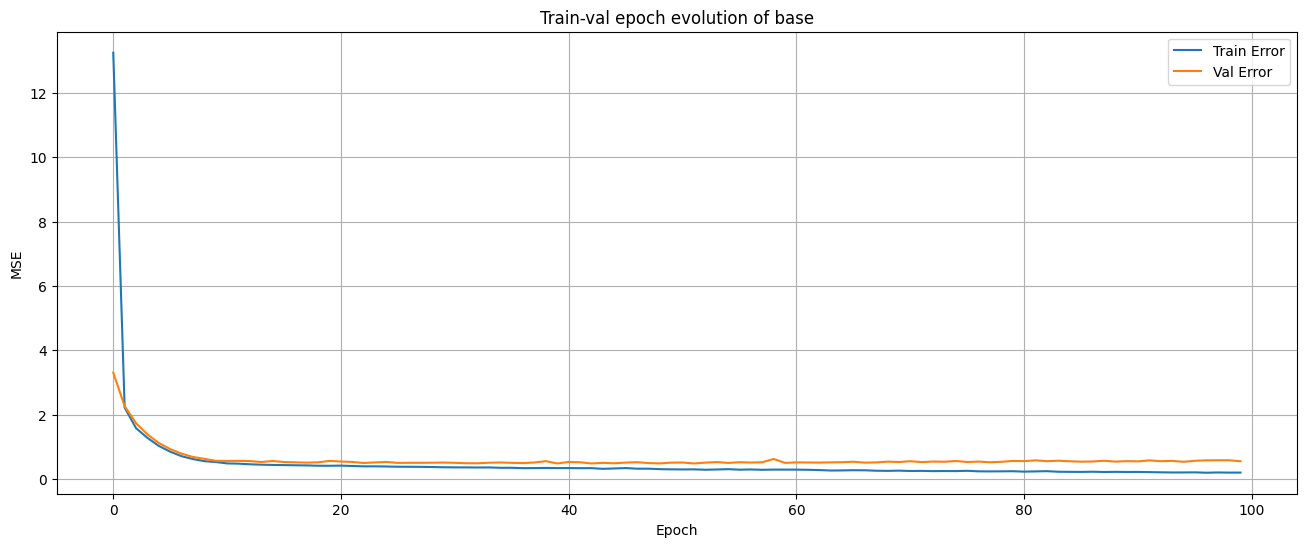

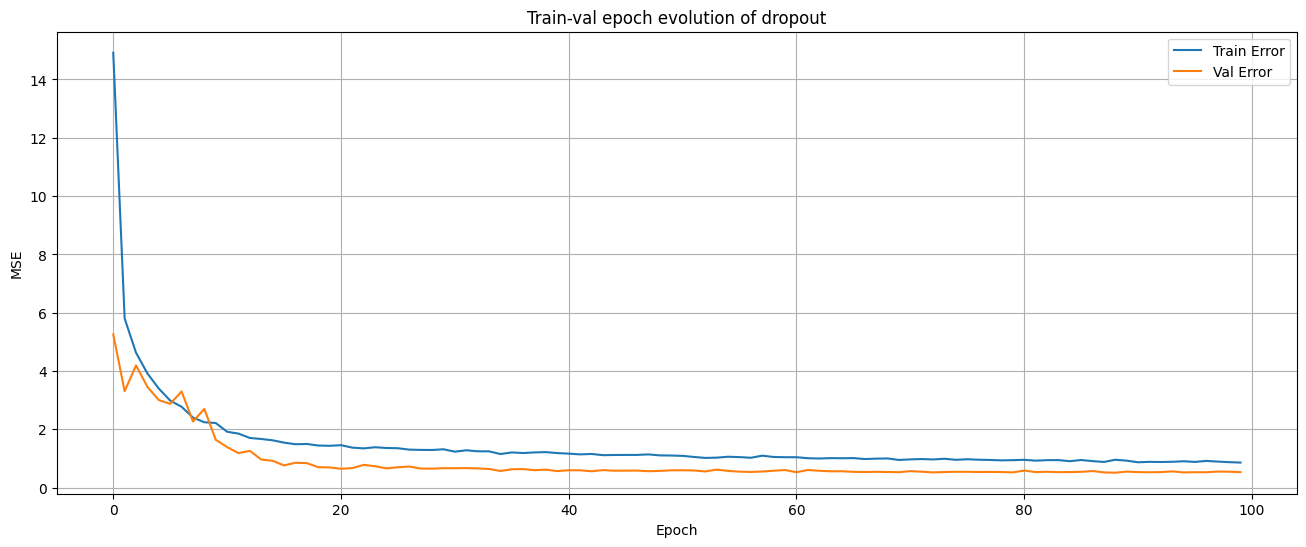

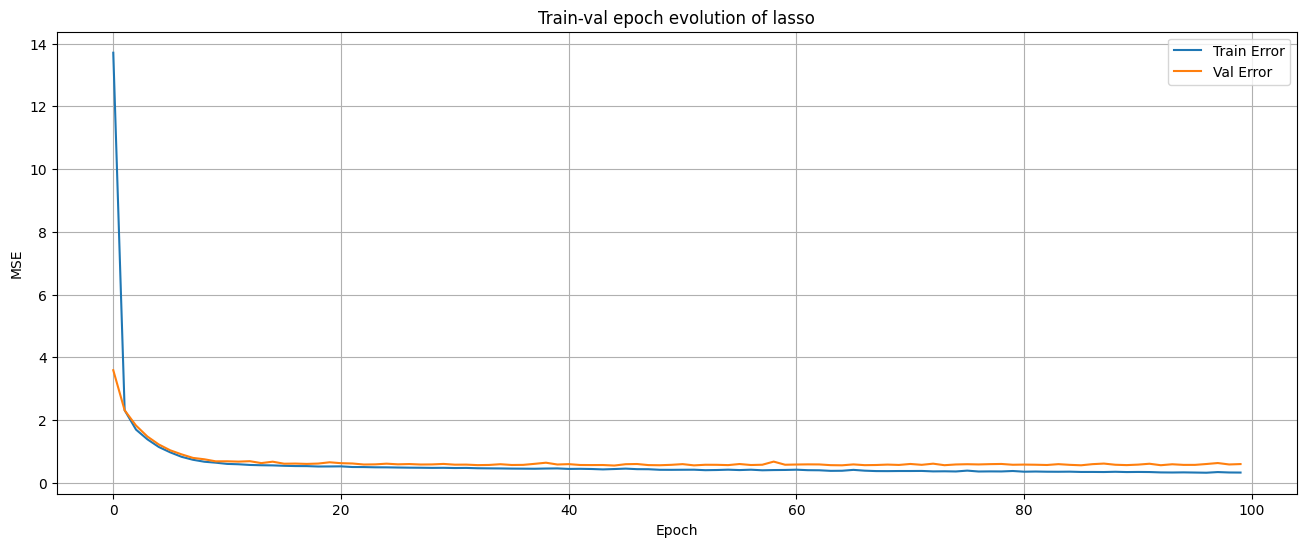

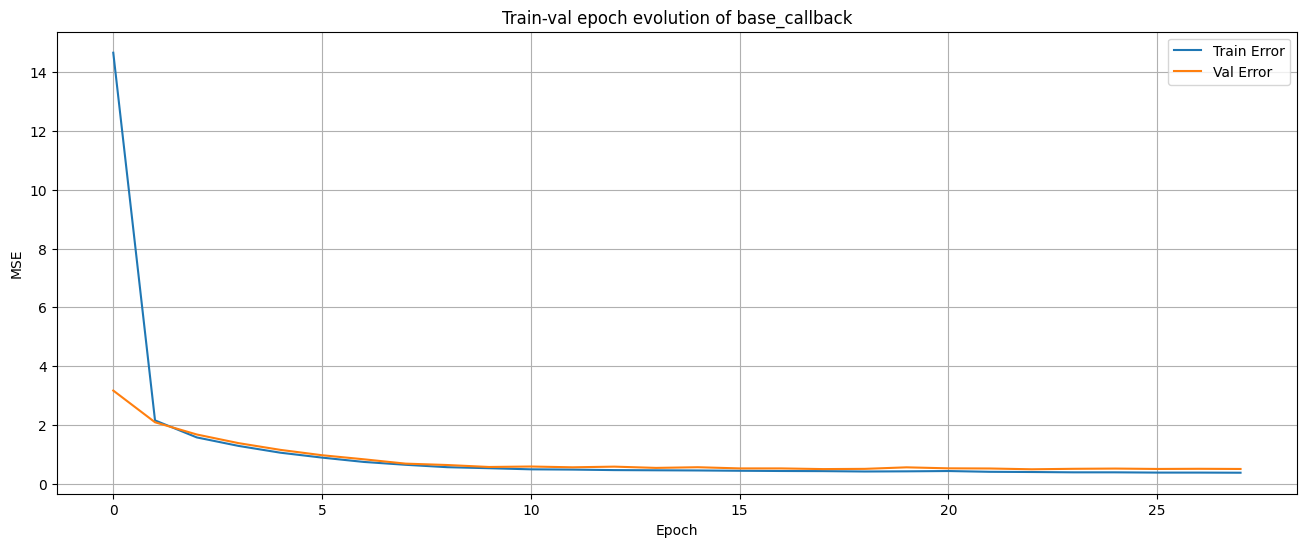

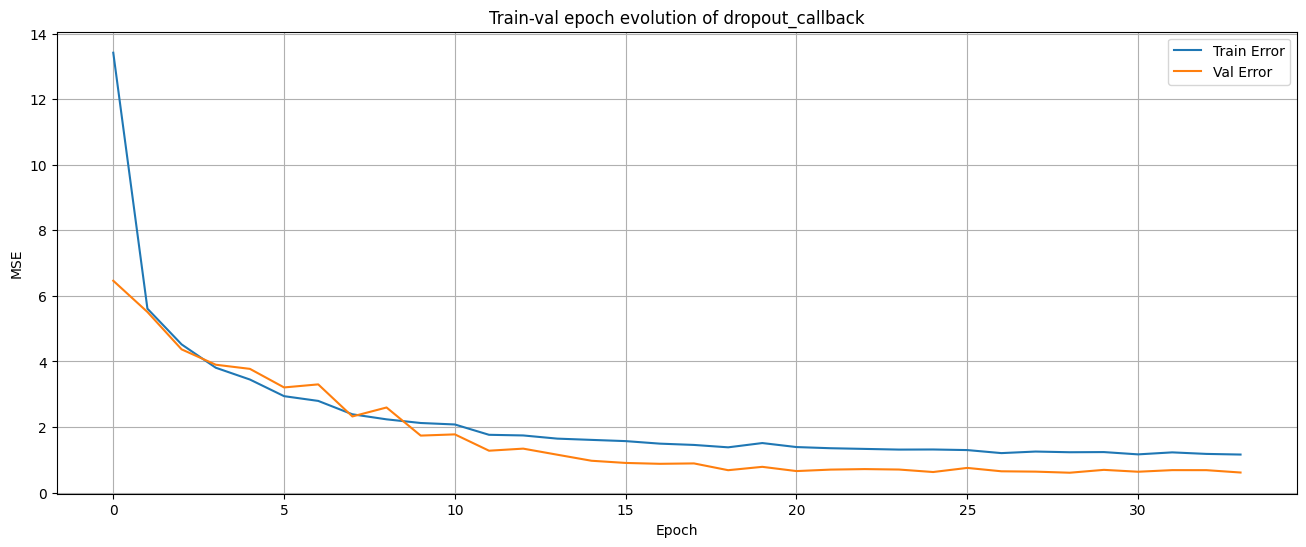

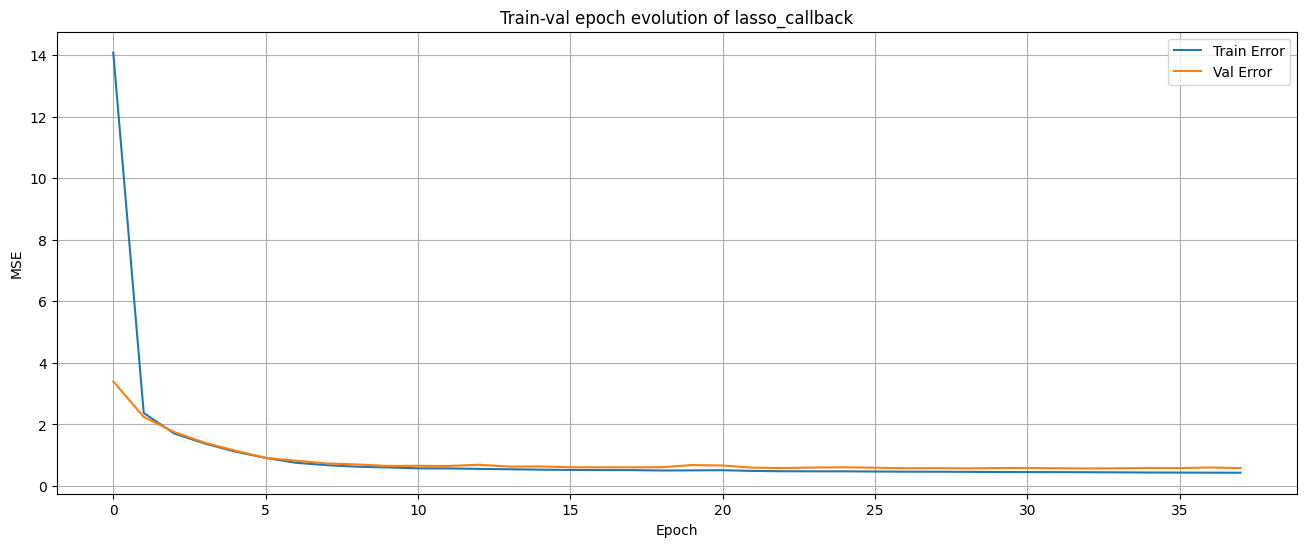

In [ ]:
fitted_models = {
    'base': model_base_fitted,
    'dropout': model_dropout_fitted,
    'lasso': model_lasso_fitted,
    'base_callback': model_base_callback_fitted,
    'dropout_callback': model_dropout_callback_fitted,
    'lasso_callback': model_lasso_callback_fitted
}

for model_name, model in fitted_models.items():
    show_loss_accuracy_evolution(model, model_name)

In [ ]:
models = {
    'base': model_base,
    'dropout': model_dropout,
    'lasso': model_lasso,
    'base_callback': model_base_callback,
    'dropout_callback': model_dropout_callback,
    'lasso_callback': model_lasso_callback
}

for model_name, model in models.items():
  test_loss, test_mae = model.evaluate(x_test_norm, y_test, verbose=0)
  print(f'Test loss (MSE) of {model_name}: {np.mean(test_loss)}. MAE: {np.mean(test_mae)}')

Test loss (MSE) of base: 0.5970089435577393. MAE: 0.5638329982757568
Test loss (MSE) of dropout: 0.5398067831993103. MAE: 0.5584486722946167
Test loss (MSE) of lasso: 0.6082820296287537. MAE: 0.5608219504356384
Test loss (MSE) of base_callback: 0.5298696756362915. MAE: 0.5632451772689819
Test loss (MSE) of dropout_callback: 0.6343355774879456. MAE: 0.6327802538871765
Test loss (MSE) of lasso_callback: 0.5986592769622803. MAE: 0.553979218006134


The MSE in the training set represents the bias error, while the difference in validation/test vs. training error represents the variance. A low variance and high bias indicates that the model might be underfitting, while the opposite, a low bias and high variance, means the model might be overfitting.

The results drawn from the test evaluation indicate that the full version and early stopped version of lasso regularization perform worse than the base model in these forms, respectively. However, as stated earlier, lasso heavily depends on the regularization term which should be tuned to perform at its best, therefore this lack of improvement could be solved by finding the optimal value for this term.

The dropout regularization method, on the other hand, performs better than the base model just without the early stoppage, which performs the poorest out of all methods. Observing the plots above, it can be seen that both bias and variance decrease over epoch though slowly. Thus, given the better test results from the not stopped version, it indicates that rather than overfitting prevention, underfitting is achieved and the patience parameter from the early stopping callback should be relaxed perhaps improving it beyond base model.

Finally, it can be affirmed than a simple early stopping strategy can greatly reduce overfitting in a base linear regression model.

On an additional final note, these comparisons could be more rigorously made through CV, having optimized each regularization method to perform a fair assessement.